#### IMPORTANT
Ensure you are utilizing 64-bit REFPROP with 64-bit python. If using the free version of REFPROP (MINI-REFPROP), please use 32-bit python and make changes to match the location where MINI-REFPROP is installed and make changes to the REFPROPFunctionLibrary function to read the REFPROP.DLL file.

Information on REFPROP and functions can be found here: https://buildmedia.readthedocs.org/media/pdf/refprop-docs/latest/refprop-docs.pdf

### IMPORT PACKAGES & FUNCTIONS

In [1]:
# Dictate the environment's loctaion of REFPROP
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'

In [2]:
# Import the main class from the Python library
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary

# Imports from conda-installable packages
import pandas as pd

# Import numpy
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import Math for common values such as PI
import math


In [3]:
# Instantiate the library, and use the environment variable to explicitly state which path we want to use.
# As mentioned above, this will be changed to call the correct REFPROP functions to be used
# with MINI-REFPROP and 32-bit python.
# If using MINI-REFPROP and 32-bit python please make the following changes
# RP = REFPROPFunctionLibrary('C:/Program FIles (x86)/MINI-REFPROP\\REFPROP.DLL')
RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])

In [4]:
# This will call which root directory that will be used for the program. 
RP.SETPATHdll(os.environ['RPPREFIX'])

In [5]:
# Get the unit system we want to use (Mass base SI gives units in
# K, Pa, kg, m, N, J, W, and s)
MASS_BASE_SI = RP.GETENUMdll(0, "MASS BASE SI").iEnum

### HEAT EXCHANGER CALCS

#### Design Parameters of Heat Exchanger

In [6]:
# Outline the parameters of the Heat Exchanger (i.e. Tube ID & OD, Pipe ID & OD, Mass Flow rates)
Tube_OD = 0.50 # [inch]
Tube_ID = 0.37 # [inch]

Tube_OD = Tube_OD * 0.0254 # [Convert inches to meters]
Tube_ID = Tube_ID * 0.0254 # [Convert inches to meters]

Pipe_ID = 2.323 # [Inch]
Pipe_ID = Pipe_ID * 0.0254 # [Convert inches to meters]

# Calculate the Hydraulic Diameter of Heat Exchanger
Hyd_Dia = (((math.pi) * Pipe_ID**2 / 4) - ((math.pi) * Tube_OD**2 / 4)) * 4 / ((math.pi) * Tube_OD + (math.pi) * Pipe_ID) # [meters]

print("Hydraulic Diameter =" , Hyd_Dia, "meters")

# Mass Flow rate of sCO2
m_dot_sCO2 = 0.20 # (kg/s)

# Thermal Conductivity of the 316 S.S. tube [W/(m*K)]
Tube_Therm = 13.4

# Thermal Resistance of the Tube
#R_cond = (math.log((Tube_OD/2)/(Tube_ID/2))) / Tube_Therm # [(m*K)/W]

Hydraulic Diameter = 0.046304200000000004 meters


#### sCO2 Properties

In [7]:
# Specify inlet conditions

P_in = 1205.3 # [psia]
T_in = 39.81 # [Celsius]

P_in = P_in * 6894.8 # convert psi to Pa
T_in = T_in + 273.15 # convert Celsius to Kelvin

In [8]:
# Obtain fluid properties from inlet conditions

sCO2_inlet = RP.REFPROPdll("CO2","PT","D;H;S;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_in,T_in,[1.0])

# Outputs will be placed into data frame for organization
sCO2_inlet = pd.DataFrame(sCO2_inlet.Output[0:6],
            index = ['Density [kg/m^3]', 'Enthalpy [J/kg]', 'Entropy [J/kg]',
                     'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['Inlet sCO2'])

# Display the data frame
sCO2_inlet

,Inlet sCO2
Density [kg/m^3],322.964569
Enthalpy [J/kg],387790.132487
Entropy [J/kg],1606.229951
Thermal Cond. [W/(mK)],0.052379
Viscosity [Pa-s],0.000024
Prandtl,3.341008


In [9]:
# Specify the desired outlet conditons 

P_out = 1180 # [psia] (This value is estimated and will be found later)
T_out = 36 # [Celsius]

P_out = P_out * 6894.8 # convert psi to Pa
T_out = T_out + 273.15 # convert Celsius to Kelvin

In [10]:
# Obtain fluid properties from the desired outlet conditions

sCO2_outlet = RP.REFPROPdll("CO2","PT","D;H;S;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_out,T_out,[1.0])

# Outputs will be placed into data frame for organization
sCO2_outlet = pd.DataFrame(sCO2_outlet.Output[0:6],
            index = ['Density [kg/m^3]', 'Enthalpy [J/kg]', 'Entropy [J/kg]',
                     'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['Outlet sCO2'])

# Display the data frame
sCO2_outlet

,Outlet sCO2
Density [kg/m^3],409.857900
Enthalpy [J/kg],356427.517027
Entropy [J/kg],1506.867295
Thermal Cond. [W/(mK)],0.078062
Viscosity [Pa-s],0.000029
Prandtl,8.193596


In [11]:
# Combine both data frames (will be used to call data for analysis)
sCO2 = pd.concat([sCO2_inlet, sCO2_outlet], axis =1)

# Display the data frame to ensure proper layout
sCO2

,Inlet sCO2,Outlet sCO2
Density [kg/m^3],322.964569,409.857900
Enthalpy [J/kg],387790.132487,356427.517027
Entropy [J/kg],1606.229951,1506.867295
Thermal Cond. [W/(mK)],0.052379,0.078062
Viscosity [Pa-s],0.000024,0.000029
Prandtl,3.341008,8.193596


In [12]:
# Find fluid properties at the mean temperature
P_mean = (P_in + P_out)/2 # [Pa] 
T_mean = (T_in + T_out)/2 # [Kelvin]


In [13]:
# Obtain fluid properties from the mean pressure and temperature

sCO2_mean = RP.REFPROPdll("CO2","PT","D;H;S;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_mean,T_mean,[1.0])

# Outputs will be placed into data frame for organization
sCO2_mean = pd.DataFrame(sCO2_mean.Output[0:6],
            index = ['Density [kg/m^3]', 'Enthalpy [J/kg]', 'Entropy [J/kg]',
                     'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['Mean sCO2'])

# Display the data frame
sCO2_mean

,Mean sCO2
Density [kg/m^3],350.283946
Enthalpy [J/kg],376521.015495
Entropy [J/kg],1570.938407
Thermal Cond. [W/(mK)],0.060212
Viscosity [Pa-s],0.000025
Prandtl,4.481146


In [14]:
# Combine into the previous data frame
sCO2 = pd.concat([sCO2, sCO2_mean], axis =1)

# Display the data frame to ensure proper layout
sCO2

,Inlet sCO2,Outlet sCO2,Mean sCO2
Density [kg/m^3],322.964569,409.857900,350.283946
Enthalpy [J/kg],387790.132487,356427.517027,376521.015495
Entropy [J/kg],1606.229951,1506.867295,1570.938407
Thermal Cond. [W/(mK)],0.052379,0.078062,0.060212
Viscosity [Pa-s],0.000024,0.000029,0.000025
Prandtl,3.341008,8.193596,4.481146


In [15]:
# Find the velocity at each of the conditions.
# This will then be used to find the respective Reynolds Number, Nusselt Number,
# and heat transfer coefficient (W/(m^2 * K))

Inlet_vel = (4 * m_dot_sCO2) / (sCO2.loc['Density [kg/m^3]', 'Inlet sCO2'] * (math.pi) * Tube_ID**2) # [m/s]
Outlet_vel = (4 * m_dot_sCO2) / (sCO2.loc['Density [kg/m^3]', 'Outlet sCO2'] * (math.pi) * Tube_ID**2) # [m/s]
Mean_vel = (4 * m_dot_sCO2) / (sCO2.loc['Density [kg/m^3]', 'Mean sCO2'] * (math.pi) * Tube_ID**2) # [m/s]

In [16]:
# Find the Reynolds Number
Inlet_Rey = sCO2.loc['Density [kg/m^3]', 'Inlet sCO2'] * Inlet_vel * Tube_ID / sCO2.loc['Viscosity [Pa-s]', 'Inlet sCO2']
Outlet_Rey = sCO2.loc['Density [kg/m^3]', 'Outlet sCO2'] * Outlet_vel * Tube_ID / sCO2.loc['Viscosity [Pa-s]', 'Outlet sCO2']
Mean_Rey = sCO2.loc['Density [kg/m^3]', 'Mean sCO2'] * Mean_vel * Tube_ID / sCO2.loc['Viscosity [Pa-s]', 'Mean sCO2']

In [17]:
# Find the Nusselt Number
Inlet_Nus = 0.0265 * Inlet_Rey**(4/5) * (sCO2.loc['Prandtl', 'Inlet sCO2'])**(0.3)
Outlet_Nus = 0.0265 * Outlet_Rey**(4/5) * (sCO2.loc['Prandtl', 'Outlet sCO2'])**(0.3)
Mean_Nus = 0.0265 * Mean_Rey**(4/5) * (sCO2.loc['Prandtl', 'Mean sCO2'])**(0.3)

In [18]:
# Using Nusselt Number, find the Heat transfer Coefficient (W/(m^2 * K))
Inlet_h_sCO2 = Inlet_Nus * (sCO2.loc['Thermal Cond. [W/(mK)]', 'Inlet sCO2']) / Tube_ID
Outlet_h_sCO2 = Outlet_Nus * (sCO2.loc['Thermal Cond. [W/(mK)]', 'Outlet sCO2']) / Tube_ID
Mean_h_sCO2 = Mean_Nus * (sCO2.loc['Thermal Cond. [W/(mK)]', 'Mean sCO2']) / Tube_ID

#### Water Properties

In [19]:
# Specify inlet conditions

P_in_water = 14.7 # [psia]
T_in_water = 25 # [Celsius]

P_in_water = P_in_water * 6894.8 # convert psi to Pa
T_in_water = T_in_water + 273.15 # convert Celsius to Kelvin

In [20]:
# Obtain fluid properties from inlet conditions

Water_inlet = RP.REFPROPdll("Water","PT","D;H;S;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_in_water,T_in_water,[1.0])

# Outputs will be placed into data frame for organization
Water_inlet = pd.DataFrame(Water_inlet.Output[0:6],
            index = ['Density [kg/m^3]', 'Enthalpy [J/kg]', 'Entropy [J/kg]',
                     'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['Inlet Water'])

# Display the data frame
Water_inlet

,Inlet Water
Density [kg/m^3],997.047650
Enthalpy [J/kg],104920.146257
Entropy [J/kg],367.199635
Thermal Cond. [W/(mK)],0.606516
Viscosity [Pa-s],0.000890
Prandtl,6.135805


In [21]:
# Using Energy Balance, find the outlet Enthalpy of the water at a specified 
# flow rate of water

Flow_water = 15 # gallons per minute of water
Flow_water = Flow_water * 0.00378541 # Convert gallons to meters cubed
m_dot_water = Flow_water / 60 * Water_inlet.loc['Density [kg/m^3]', 'Inlet Water']
m_dot_water

0.9435585358597339

In [22]:
# Conduct Energy Balance and find the outlet enthalpy

Water_Outlet_Enth = ((m_dot_sCO2 * (sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - sCO2.loc['Enthalpy [J/kg]', 'Outlet sCO2']) / m_dot_water + Water_inlet.loc['Enthalpy [J/kg]', 'Inlet Water']))
Water_Outlet_Enth # [J/kg]

111567.87700553813

In [23]:
# Obtain fluid properties for outlet conditions

Water_outlet = RP.REFPROPdll("Water","PH","T;D;S;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_in_water,Water_Outlet_Enth,[1.0])

# Outputs will be placed into data frame for organization
Water_outlet = pd.DataFrame(Water_outlet.Output[0:6],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Entropy [J/kg]',
                     'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['Outlet Water'])

# Display the data frame
Water_outlet

,Outlet Water
Temperature [K],299.739983
Density [kg/m^3],996.627844
Entropy [J/kg],389.436993
Thermal Cond. [W/(mK)],0.609086
Viscosity [Pa-s],0.000859
Prandtl,5.894031


In [24]:
# Combine both data frames (will be used to call data for analysis)
Water = pd.concat([Water_inlet, Water_outlet], axis =1)

# Add data into the data frame
Water.loc['Enthalpy [J/kg]', 'Outlet Water'] = Water_Outlet_Enth
Water.loc['Temperature [K]', 'Inlet Water'] = T_in_water
# Display the data frame to ensure proper layout
Water

,Inlet Water,Outlet Water
Density [kg/m^3],997.047650,996.627844
Enthalpy [J/kg],104920.146257,111567.877006
Entropy [J/kg],367.199635,389.436993
Thermal Cond. [W/(mK)],0.606516,0.609086
Viscosity [Pa-s],0.000890,0.000859
Prandtl,6.135805,5.894031
Temperature [K],298.150000,299.739983


In [25]:
# Find the mean Velocity of Water flowing
Water_vel = 4 * m_dot_water / (((Water.loc['Density [kg/m^3]', 'Inlet Water'] + Water.loc['Density [kg/m^3]', 'Outlet Water'])/2) \
             * math.pi * Hyd_Dia**2)

Water_vel # [m/s]

0.5621001755631613

In [26]:
# Find the Reynolds Number
Water_Rey = ((Water.loc['Density [kg/m^3]', 'Inlet Water'] + Water.loc['Density [kg/m^3]', 'Outlet Water'])/2) * \
            Water_vel * Hyd_Dia / ((Water.loc['Viscosity [Pa-s]', 'Inlet Water'] + Water.loc['Viscosity [Pa-s]', 'Outlet Water'])/2)

Water_Rey

29673.493169376692

In [27]:
# Find the Nusselt Number
Water_Nus = 0.0243 * Water_Rey**(4/5) * \
            ((Water.loc['Prandtl', 'Inlet Water'] + Water.loc['Prandtl', 'Outlet Water'])/2)**(0.4)

Water_Nus

188.44867505735397

In [28]:
# Using Nusselt Number, find the Heat transfer Coefficient (W/(m^2 * K))
h_Water = Water_Nus * ((Water.loc['Thermal Cond. [W/(mK)]', 'Inlet Water'] + Water.loc['Thermal Cond. [W/(mK)]', 'Outlet Water'])/2)\
            / Hyd_Dia

h_Water

2473.6257285927422

#### Analysis of Heat Exchanger

In [29]:
# Find the log mean temperature difference
Delta_T1 = T_in - Water.loc['Temperature [K]', 'Outlet Water']
Delta_T2 = T_out - Water.loc['Temperature [K]', 'Inlet Water']

Log_Mean_T = (Delta_T2 - Delta_T1) / math.log(Delta_T2/Delta_T1)
Log_Mean_T

12.07601773124735

In [30]:
# Approximate resistance of the cylindrical tube using the slab formula 
# L/(kA)

Rt_cond_approx = (Tube_OD - Tube_ID) / (2 * Tube_Therm) # [(m^2 * K) / W]
Rt_conv_sCO2 = 1 / Inlet_h_sCO2 # [(m^2 * K) / W]
Rt_conv_Water = 1 / h_Water

U_inlet = 1 / (Rt_cond_approx + Rt_conv_sCO2 + Rt_conv_Water)
U_inlet

1680.175435067763

In [31]:
# Find the Length of tube neccessary for the Heat Exchanger
Length = (m_dot_sCO2 * (sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - sCO2.loc['Enthalpy [J/kg]', 'Outlet sCO2']))\
          / (U_inlet * Log_Mean_T * math.pi * Tube_OD)

Length = Length * 3.28084 # Converts meters to feet
Length # This length uses inlet conditions of sCO2 to approximate length in feet

25.421159383130938

In [32]:
# Approximate resistance of the cylindrical tube using the slab formula 
# L/(kA)

Rt_cond_approx = (Tube_OD - Tube_ID) / (2 * Tube_Therm) # [(m^2 * K) / W]
Rt_conv_sCO2 = 1 / Outlet_h_sCO2 # [(m^2 * K) / W]
Rt_conv_Water = 1 / h_Water

U_outlet = 1 / (Rt_cond_approx + Rt_conv_sCO2 + Rt_conv_Water)
U_outlet

1762.1301199485404

In [33]:
Length = (m_dot_sCO2 * (sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - sCO2.loc['Enthalpy [J/kg]', 'Outlet sCO2']))\
          / (U_outlet * Log_Mean_T * math.pi * Tube_OD)

Length = Length * 3.28084 # Converts meters to feet
Length # This length uses outlet conditions of sCO2 to approximate length in feet

24.238849925410896

In [34]:
# Approximate resistance of the cylindrical tube using the slab formula 
# L/(kA)

Rt_cond_approx = (Tube_OD - Tube_ID) / (2 * Tube_Therm) # [(m^2 * K) / W]
Rt_conv_sCO2 = 1 / Mean_h_sCO2 # [(m^2 * K) / W]
Rt_conv_Water = 1 / h_Water

U_mean = 1 / (Rt_cond_approx + Rt_conv_sCO2 + Rt_conv_Water)
U_mean

1713.174656776471

In [35]:
Length = (m_dot_sCO2 * (sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - sCO2.loc['Enthalpy [J/kg]', 'Outlet sCO2']))\
          / (U_mean * Log_Mean_T * math.pi * Tube_OD)

Length = Length * 3.28084 # Converts meters to feet
Length # This length uses mean conditions of sCO2 to approximate length in feet

24.931496247350733

In [36]:
# Total Heat Dissipated with Heat Exchanger
Q_Loss = -m_dot_sCO2 * (sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - sCO2.loc['Enthalpy [J/kg]', 'Outlet sCO2'])
Q_Loss/1000

-6.272523092028034

#### Pinch Temperature Analysis

In [37]:
# Find the Chnage in enthalpy and the change in pressure of both streams (sCO2 and Water)
delta_h_hot = sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - sCO2.loc['Enthalpy [J/kg]', 'Outlet sCO2']
delta_h_cold = Water.loc['Enthalpy [J/kg]', 'Outlet Water'] - Water.loc['Enthalpy [J/kg]', 'Inlet Water']

delta_p_sCO2 = P_in - P_out

In [38]:
# Iterate for Temperature development of sCO2

T_sCO2 = []

for k in range(0,11):
    P =  P_in - (delta_p_sCO2 * k/10)
    H = sCO2.loc['Enthalpy [J/kg]', 'Inlet sCO2'] - (delta_h_hot * k/10)
    sCO2_T = RP.REFPROPdll("CO2","PH","T", MASS_BASE_SI,0,0, P, H,[1.0]).Output[0]
    T_sCO2.append(sCO2_T)
    
print(T_sCO2)  

[312.9600001045175, 312.4261930799648, 311.9327940989634, 311.4774707407188, 311.05780749464793, 310.67134074410774, 310.3155895472092, 309.98807464388693, 309.68631764192924, 309.4078161290739, 309.15000005114456]


In [39]:
# Iterate for Temperature development of Water

T_Water = []
Enth_Change = []
for k in range(0,11):
    H = Water.loc['Enthalpy [J/kg]', 'Outlet Water'] - (delta_h_cold * k/10)
    Water_T = RP.REFPROPdll("Water","PH","T", MASS_BASE_SI,0,0, P_in_water, H,[1.0]).Output[0]
    T_Water.append(Water_T)
    
    Enth_Change.append(k/10)
    
print(T_Water)  

[299.7399826449107, 299.5809744998648, 299.4219684321178, 299.26296448540614, 299.1039627038485, 298.9449631318276, 298.785965814264, 298.62697079644175, 298.46797812397546, 298.3089878430954, 298.1500000003136]


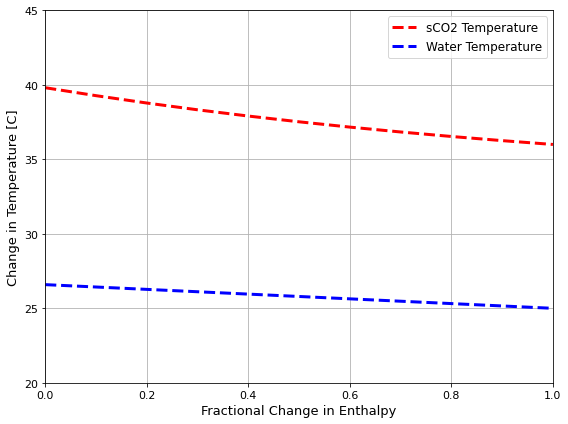

In [40]:
# Plot Pinch Temperature 
T_Water = np.array(T_Water) - 273.15
T_sCO2 = np.array(T_sCO2) - 273.15

plt.figure(figsize=(8,6), tight_layout=True)

plt.plot(Enth_Change, T_sCO2, 'r--', linewidth = 3 , label = "sCO2 Temperature" )
plt.plot(Enth_Change, T_Water, 'b--', linewidth = 3 , label = "Water Temperature")
plt.grid(True)
plt.axis([0,1,20,45])
plt.xlabel('Fractional Change in Enthalpy', fontsize = 13)
plt.ylabel('Change in Temperature [C]', fontsize = 13)
plt.legend(loc = "upper right" , fontsize=12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

plt.savefig('Pinch_Temperature.png',bbox_inches='tight')
plt.show()